# Pflanzenkrankheiten erkennen mit Plant-Village & CNN

## Problemstellung:
Pflanzenkrankheiten frühzeitig zu erkennen ist für Hobbygärtner wie auch für professionelle Landschaftsgärtner wichtig, um Ernteausfälle und Pflanzenschäden zu vermeiden. Viele Krankheiten sehen aif den ersten Blick ähnlich aus, weshalb eine automatische Erkennung per Computer Vision sehr hilfreich sein kann.

## Ziel des Projektes:
Wie entwickeln aus diesem Grund ein Convolutional Neural Network (CNN), welches anhand von Bildern von Pflanzenblättern, ob die Pflanze gesund ist oder an einer bestimmten Krankheit leidet.

In [2]:
# -- Basis-Imports --
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- Machine Learning / Deep Learning --
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50V2, EfficientNetB0
)

# -- Tools --
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [147]:
def show_misclassifications(model, test_flow, test_df, class_names, num_examples=6):
    # Testflow Reset
    test_flow.reset()

    # Vorhersagen
    pred = model.predict(test_flow)
    pred_classes = np.argmax(pred, axis=1)

    # wahre Labels
    true_classes = test_flow.classes

    # Fehler finden
    errors = np.where(pred_classes != true_classes)[0]

    print("Anzahl Fehlklassifikationen:", len(errors))

    for i in errors[:num_examples]:
        img_path = test_df.iloc[i]["path"]

        plt.imshow(plt.imread(img_path))
        plt.title(
            f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}",
            fontsize=12
        )
        plt.axis("off")
        plt.show()


## Datenbeschaffung
In dem Projekt wird der Plant-Village Datensatz benutzt, der über Kaggle zur Verfügung steht. Der Datenstz enthält über 20000 Bilder von Pflenzenblättern

### Vorteile:
- viele Bilder
- hohe Bildqualität
- klare Ordnerstruktur
  
### Nachteile:
- Bilder wurden unter sehr guten Bedingungen aufgenommen -> Outdoor-Bilder unterscheiden sich stark
- einige Klassen sind unbalanciert
- Krankheiten sehen teilweise sehr änhlich aus 


In [5]:
import kagglehub

# letzte Version downloaden
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /Users/emilykruger/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


## Explorative Datenanalyse (EDA): Klassenübersicht und Beispielbilder

Datensatzordner: /Users/emilykruger/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage/PlantVillage
Anzahl Klassen: 15
Beispeilklassen: ['Tomato_healthy', 'Potato___Early_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus']

Bilder pro Klasse:
Tomato_healthy: 1591
Potato___Early_blight: 1000
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
Tomato_Early_blight: 1000
Tomato__Target_Spot: 1404
Potato___Late_blight: 1000
Tomato_Leaf_Mold: 952
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato_Septoria_leaf_spot: 1771
Tomato__Tomato_mosaic_virus: 373
Pepper__bell___Bacterial_spot: 997
Tomato_Bacterial_spot: 2127
Tomato_Late_blight: 1909
Pepper__bell___healthy: 1478
Potato___healthy: 152

Gesamtanzahl aller Bilder im Datensatz: 20638


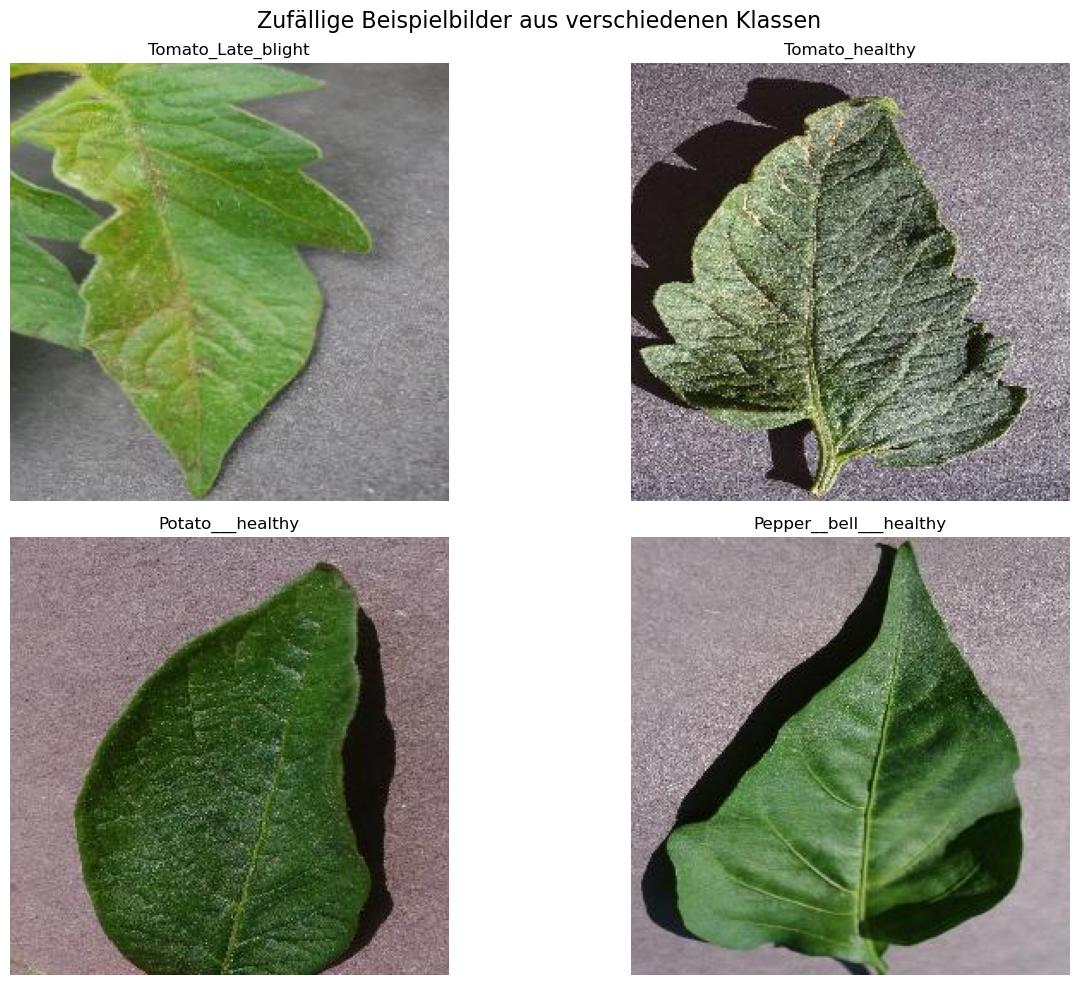

In [8]:
import random
from PIL import Image

# Richtiger PlantVillage-Datenordner
dataset_dir = os.path.join(path, "PlantVillage", "PlantVillage")

print("Datensatzordner:", dataset_dir)

# --- Klassenordner laden ---
folders = [
    f for f in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, f))
]

print("Anzahl Klassen:", len(folders))
print("Beispeilklassen:", folders[:10])

# --- Bilder pro Klasse zählen ---
class_counts = {}
total_images = 0 

for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    class_counts[cls] = len(images)
    total_images += len(images)

print("\nBilder pro Klasse:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print(f"\nGesamtanzahl aller Bilder im Datensatz: {total_images}")

# --- Beispielbilder anzeigen ---
sample_classes = random.sample(folders, 4)

plt.figure(figsize=(14, 10))
for i, cls in enumerate(sample_classes):
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    if not images:
        continue  # überspringt leere Ordner, falls vorhanden
    
    img_path = os.path.join(cls_path, random.choice(images))
    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)  # 2x2 Layout
    plt.imshow(img)
    plt.title(cls, fontsize=12)
    plt.axis("off")

plt.suptitle("Zufällige Beispielbilder aus verschiedenen Klassen", fontsize=16)
plt.tight_layout()
plt.show()


### Barplot der Klassenverteilung 

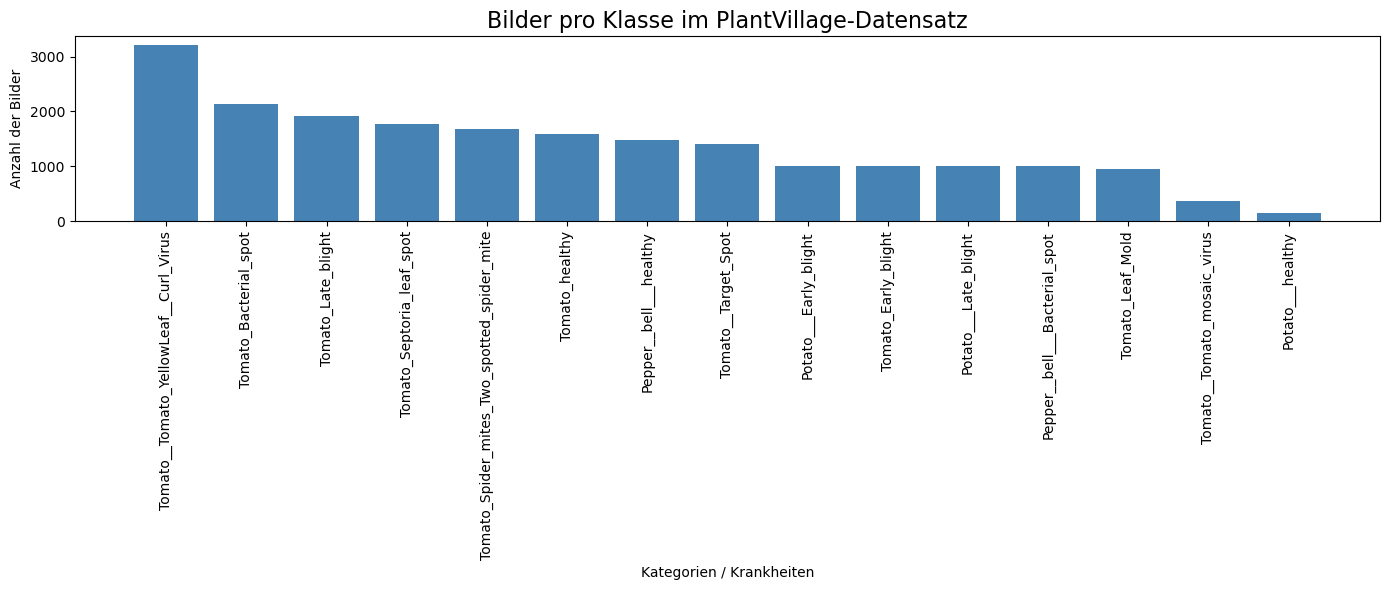

In [11]:
# Dictionary in DataFrame umwandeln
class_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
class_df = class_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(class_df.index, class_df['count'], color='steelblue')
plt.xticks(rotation=90)
plt.title("Bilder pro Klasse im PlantVillage-Datensatz", fontsize=16)
plt.xlabel("Kategorien / Krankheiten")
plt.ylabel("Anzahl der Bilder")
plt.tight_layout()
plt.show()


## Erstellung eines DataFrames

- alle Bildpfade und die zugehörigen Labels aus den Klassenordnern gesammelt
- DataFrame als DataLoader um die Bilder korrekt einzulesen und dem Modell die passenden Zielklassen zuzuordnen

In [14]:
image_paths = []
labels = []

# Durchlaufe jede Klasse und sammle Bildpfade
for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    for img in images:
        image_paths.append(os.path.join(cls_path, img))
        labels.append(cls)

# In DataFrame überführen
df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

print(len(df))
df.head()


20638


path           label
0  /Users/emilykruger/.cache/kagglehub/datasets/e...  Tomato_healthy
1  /Users/emilykruger/.cache/kagglehub/datasets/e...  Tomato_healthy
2  /Users/emilykruger/.cache/kagglehub/datasets/e...  Tomato_healthy
3  /Users/emilykruger/.cache/kagglehub/datasets/e...  Tomato_healthy
4  /Users/emilykruger/.cache/kagglehub/datasets/e...  Tomato_healthy

## Train/Val/Test Split

In [17]:
# --- 1. Split: Train + Temp (Val+Test) ---
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,     # 70% Train, 30% Temp
    stratify=df["label"],
    random_state=42
)

# --- 2. Split: Temp -> Validation + Test ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,     # Hälfte der 30% -> 15% Test, 15% Val
    stratify=temp_df["label"],
    random_state=42
)

# --- Ausgabe der Größen ---
print("Größe der Datensplits:")
print("Training:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

# --- Prüfung: Anzahl Klassen unverändert? ---
print("\nAnzahl Klassen:")
print("Train:", train_df["label"].nunique())
print("Val:", val_df["label"].nunique())
print("Test:", test_df["label"].nunique())

Größe der Datensplits:
Training: 14446
Validation: 3096
Test: 3096

Anzahl Klassen:
Train: 15
Val: 15
Test: 15


## ImageDataGenerator + Augmentation + Data Pipeline

In [83]:
IMG_SIZE = (128, 128)  # niedriger gestellt, damit Training nicht so lang dauert 
BATCH_SIZE = 32

# --- Trainingsgenerator (mit Augmentation) ---
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# --- Validierungs- & Testgenerator (ohne Augmentation) ---
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# --- Generatoren erstellen ---
train_flow = train_gen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_flow = val_gen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_flow = test_gen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Test-Set nie mischen
)


Found 14446 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.


## Baseline-CNN

In [86]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding="same", input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(folders), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Early Stopping zur Vermeidung von Overfitting

In [88]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

### Training des CNN-Modells

In [90]:
# --- Training ---
history = model.fit(
    train_flow, 
    epochs=5, 
    validation_data=val_flow, 
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.2914 - loss: 2.1954 - val_accuracy: 0.4483 - val_loss: 1.7489
Epoch 2/5
452/452 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.5724 - loss: 1.3092 - val_accuracy: 0.6783 - val_loss: 1.0073
Epoch 3/5
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.6600 - loss: 1.0370 - val_accuracy: 0.7284 - val_loss: 0.8371
Epoch 4/5
452/452 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.7148 - loss: 0.8664 - val_accuracy: 0.7229 - val_loss: 0.8375
Epoch 5/5
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - accuracy: 0.7459 - loss: 0.7673 - val_accuracy: 0.7852 - val_loss: 0.6709


### Plots erstellen 

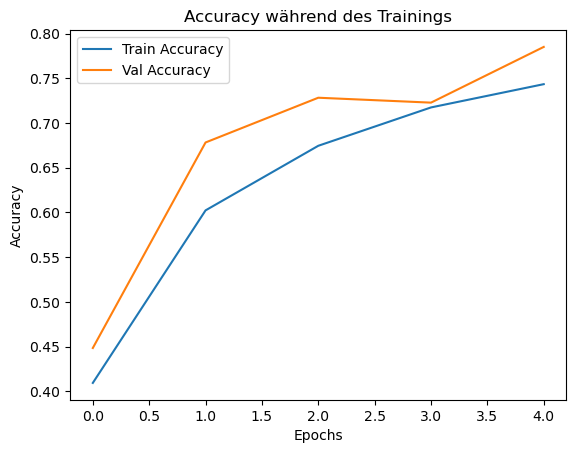

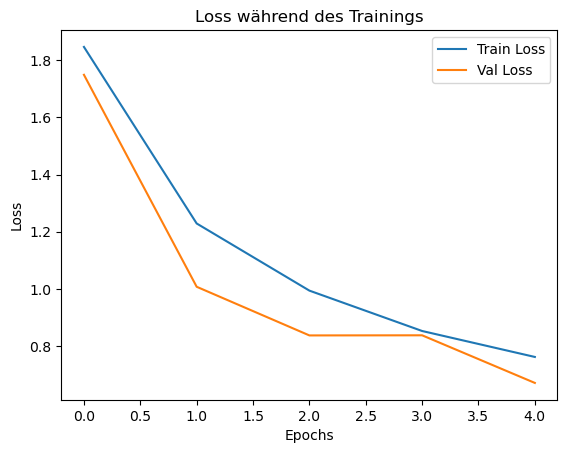

In [92]:
# --- Plots ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy während des Trainings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss während des Trainings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Modellvorhersage auf dem Testdatensatz

In [95]:
test_flow.reset()

# Vorhersagen
y_pred = model.predict(test_flow)
y_pred_classes = np.argmax(y_pred, axis=1)

# Wahre Labels
y_true = test_flow.classes

# Klassennamen
class_names = list(test_flow.class_indices.keys())

print("Anzahl der Testbilder:", len(y_true))

 1/97 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Anzahl der Testbilder: 3096


### Auswertung der Modellleistung mit dem Classification Report

In [97]:
print(classification_report(
    y_true, 
    y_pred_classes, 
    target_names=class_names    
))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.72      0.74      0.73       149
                     Pepper__bell___healthy       0.90      0.86      0.88       221
                      Potato___Early_blight       0.84      0.93      0.88       150
                       Potato___Late_blight       0.78      0.81      0.79       150
                           Potato___healthy       0.67      0.17      0.28        23
                      Tomato_Bacterial_spot       0.94      0.87      0.90       319
                        Tomato_Early_blight       0.83      0.36      0.50       150
                         Tomato_Late_blight       0.82      0.79      0.80       287
                           Tomato_Leaf_Mold       0.81      0.72      0.76       143
                  Tomato_Septoria_leaf_spot       0.79      0.55      0.65       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.58      0.89

### Konfusionsmatrix zur Analyse der Modellfehler

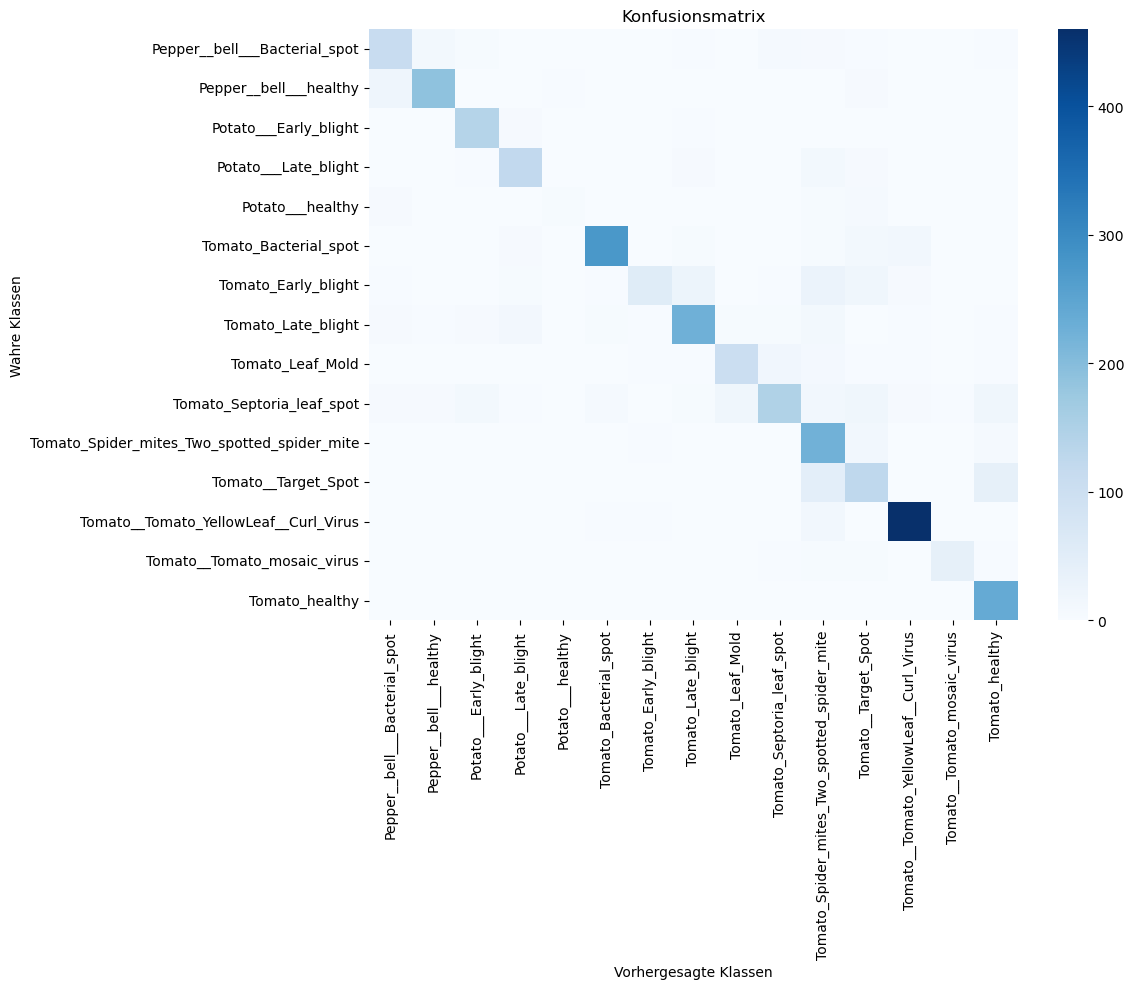

In [99]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Vorhergesagte Klassen")
plt.ylabel("Wahre Klassen")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()

## Transfer Learning 
### EfficientNet

In [137]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

efficient_train_flow = train_gen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),     # höher als Baseline, weil Modell höhere Auflöung braucht
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

efficient_val_flow = val_gen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

efficient_test_flow = test_gen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224), 
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)  # höhere Bildauflösung, da Modell sonst nicht gut funktioniert 
)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(folders), activation='softmax')(x)

efficient_model = Model(base_model.input, output)

efficient_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

efficient_model.summary()

history_eff = efficient_model.fit(
    efficient_train_flow,  
    epochs=3, 
    validation_data=efficient_val_flow,
    callbacks=[early_stopping],
    verbose=1
)

eff_val_acc = max(history_eff.history["val_accuracy"])
print("EfficientNetB0 – Beste Validation Accuracy:", eff_val_acc)

Found 14446 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 224, 224,  │          0 │ input_layer_18[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 224, 224,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 224, 224,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,132,530 (15.76 MB)

 Trainable params: 82,959 (324.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/Applications/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 173s 376ms/step - accuracy: 0.1327 - loss: 2.6161 - val_accuracy: 0.1554 - val_loss: 2.5706
Epoch 2/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 162s 359ms/step - accuracy: 0.1539 - loss: 2.5815 - val_accuracy: 0.1554 - val_loss: 2.5694
Epoch 3/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 163s 361ms/step - accuracy: 0.1546 - loss: 2.5762 - val_accuracy: 0.1554 - val_loss: 2.5743
EfficientNetB0 – Beste Validation Accuracy: 0.15536175668239594


### MobileNet

In [110]:
from tensorflow.keras.applications import MobileNetV2

# --- Basis-Modell laden ---
base_model_mn = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model_mn.trainable = False  # Freeze aller Layer

# --- Klassifikationskopf ---
x = GlobalAveragePooling2D()(base_model_mn.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(folders), activation='softmax')(x)

mobilenet_model = Model(base_model_mn.input, output)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

# --- Training ---
history_mn = mobilenet_model.fit(
    train_flow, 
    epochs=3, 
    validation_data=val_flow, 
    callbacks=[early_stopping],
    verbose=1
)

# --- Beste Accuracy speichern ---
mn_val_acc = max(history_mn.history["val_accuracy"])
print("MobileNetV2 - Beste Validation Accuracy:", mn_val_acc)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,340,943 (8.93 MB)

 Trainable params: 82,959 (324.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 45s 97ms/step - accuracy: 0.5757 - loss: 1.3904 - val_accuracy: 0.7768 - val_loss: 0.6997
Epoch 2/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.7830 - loss: 0.6493 - val_accuracy: 0.8120 - val_loss: 0.5762
Epoch 3/3
452/452 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.8199 - loss: 0.5317 - val_accuracy: 0.8314 - val_loss: 0.5122
MobileNetV2 - Beste Validation Accuracy: 0.8313953280448914


### ResNet

In [113]:
from tensorflow.keras.applications import ResNet50V2

# --- Basis-Modell laden ---
base_model_res = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model_res.trainable = False  # Freeze

# --- Klassifikationskopf ---
x = GlobalAveragePooling2D()(base_model_res.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(folders), activation='softmax')(x)

resnet_model = Model(base_model_res.input, output)

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

# --- Training ---
history_res = resnet_model.fit(
    train_flow, 
    epochs=3,
    validation_data=val_flow, 
    callbacks=[early_stopping],
    verbose=1
)

# --- Beste Accuracy speichern ---
res_val_acc = max(history_res.history["val_accuracy"])
print("ResNet50V2 - Beste Validation Accuracy:", res_val_acc)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 23,696,911 (90.40 MB)

 Trainable params: 132,111 (516.06 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 148s 323ms/step - accuracy: 0.4985 - loss: 1.5952 - val_accuracy: 0.7342 - val_loss: 0.7867
Epoch 2/2
452/452 ━━━━━━━━━━━━━━━━━━━━ 141s 312ms/step - accuracy: 0.7103 - loss: 0.8689 - val_accuracy: 0.7742 - val_loss: 0.6724
ResNet50V2 - Beste Validation Accuracy: 0.7742248177528381


#### Modellvergleich

            Model  Val Accuracy
0        Baseline      0.785207
1  EfficientNetB0      0.155362
2     MobileNetV2      0.831395
3      ResNet50V2      0.774225


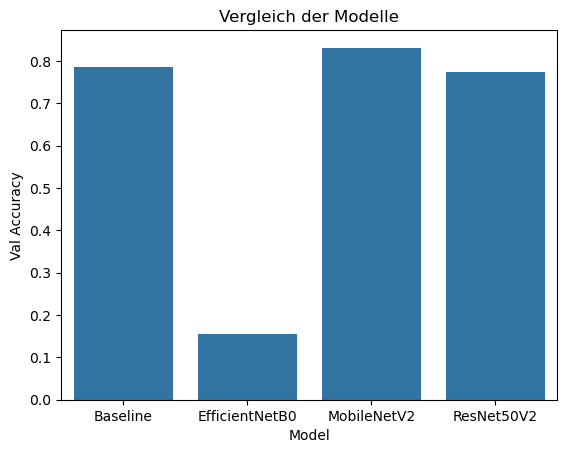

In [139]:
results = pd.DataFrame({
    "Model": ["Baseline", "EfficientNetB0", "MobileNetV2", "ResNet50V2"],
    "Val Accuracy": [
        max(history.history["val_accuracy"]),
        max(history_eff.history["val_accuracy"]),
        max(history_mn.history["val_accuracy"]),
        max(history_res.history["val_accuracy"])
    ]
})

print(results)

sns.barplot(data=results, x="Model", y="Val Accuracy")
plt.title("Vergleich der Modelle")
plt.show()


#### Fehlklassifikation

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Anzahl Fehlklassifikationen: 640


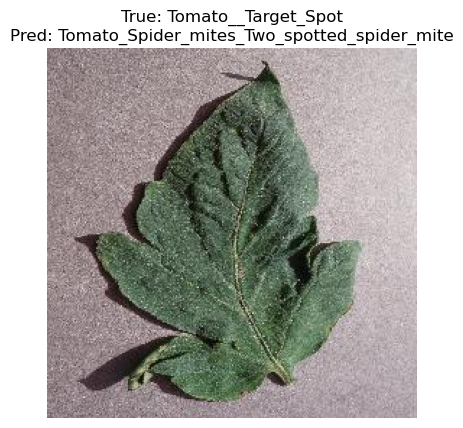

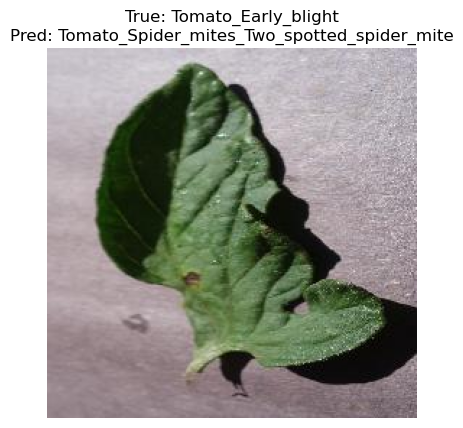

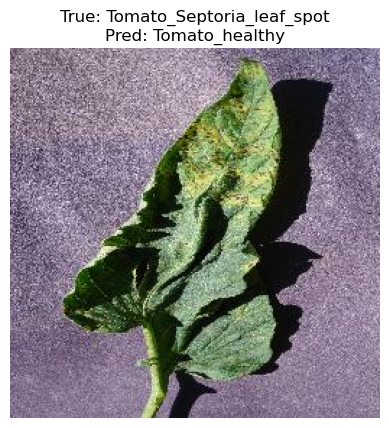

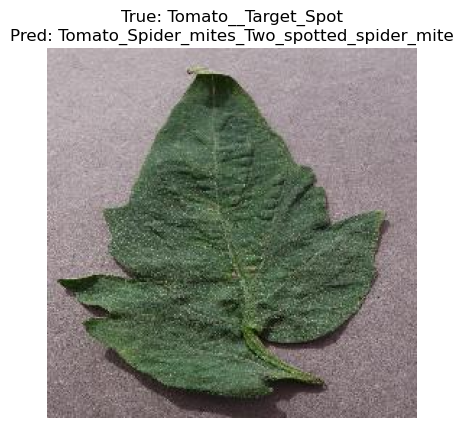

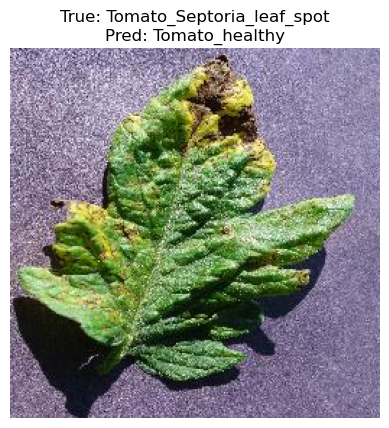

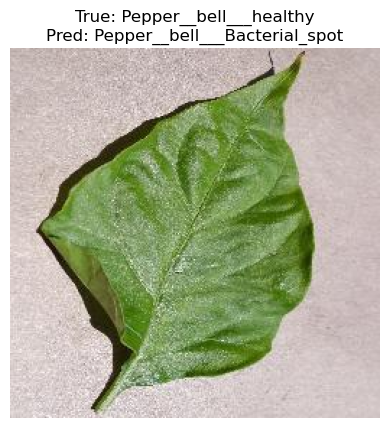

In [149]:
show_misclassifications(model, test_flow, test_df, class_names)


97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step
Anzahl Fehlklassifikationen: 2614


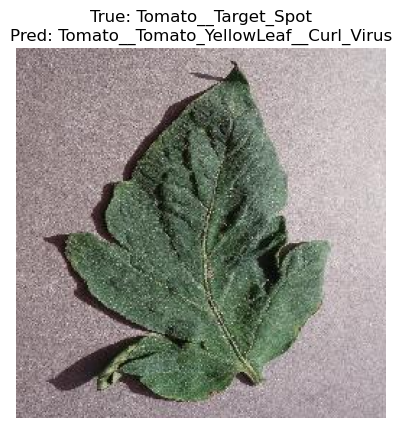

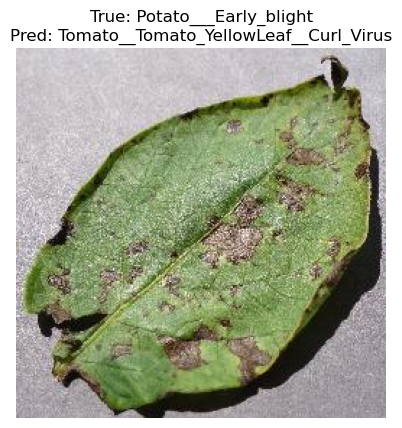

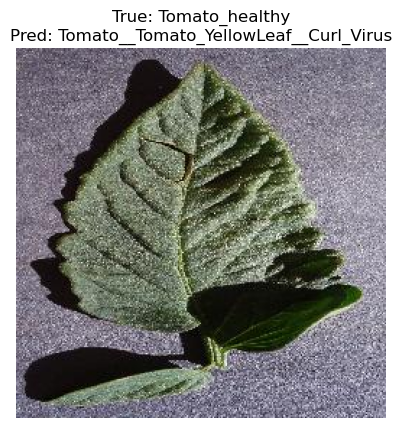

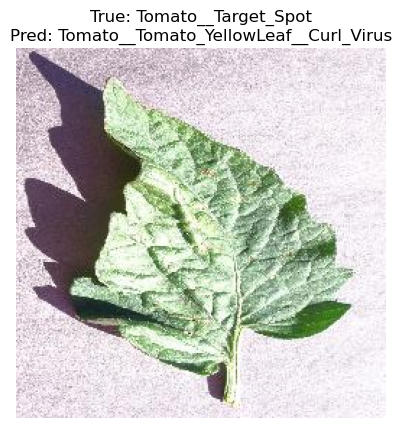

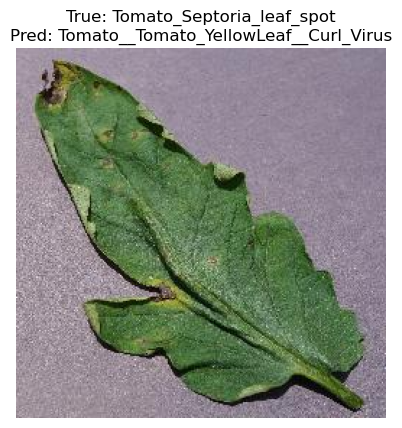

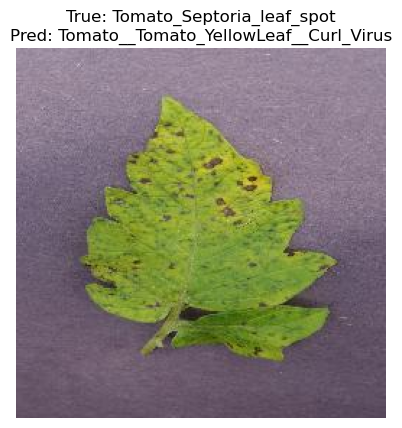

In [151]:
show_misclassifications(efficient_model, efficient_test_flow, test_df, class_names)


97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step
Anzahl Fehlklassifikationen: 522


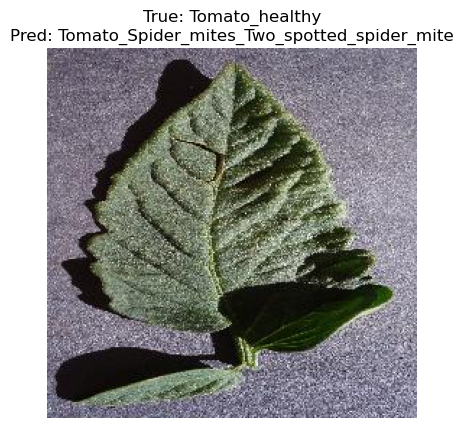

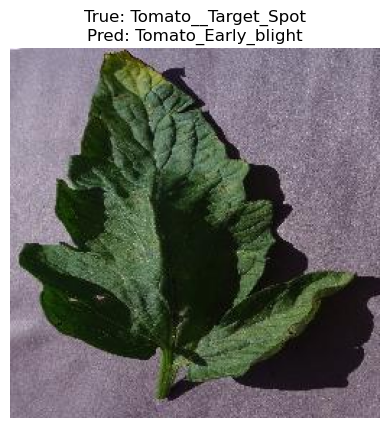

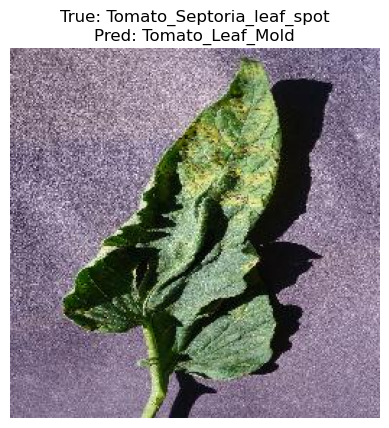

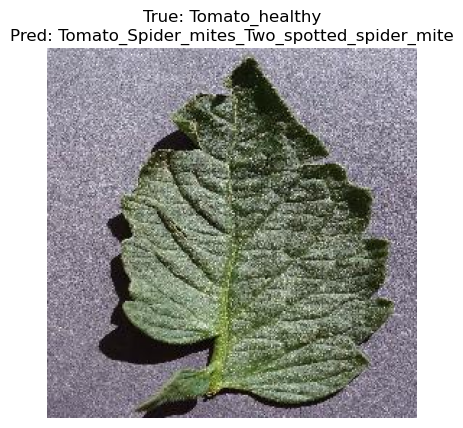

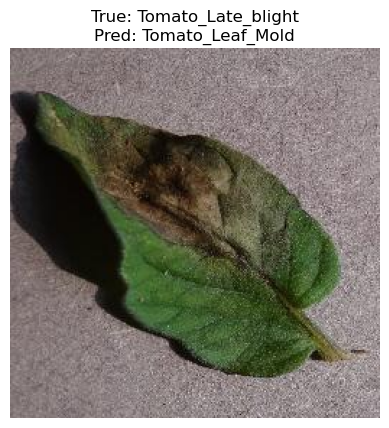

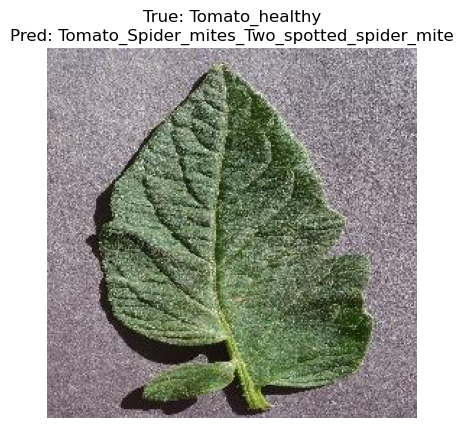

In [153]:
show_misclassifications(mobilenet_model, test_flow, test_df, class_names)


In [ ]:
show_misclassifications(resnet_model, test_flow, test_df, class_names)


71/97 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step